In [2]:
# essentials
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os

import tensorflow as tf

import config
from utils.DataGenerator import DataGenerator

## Loading models and vocabulary

In [3]:
model = tf.keras.models.load_model(config.NN_MODEL_DIR + "model-acc16-loss4.91.h5")

In [4]:
with open("vocabularies/vocabulary_small.pkl", 'rb') as file:
    vocabulary = pickle.load(file)

with open("models/word2vecs/wholedataset-win7-vec200-min20.pkl", 'rb') as file:
    word2vec = pickle.load(file)

with open(os.path.join(config.NN_MODEL_DIR, "training_logs.pkl"), 'rb') as file:
    training_logs = pickle.load(file)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-24 09:43:00         3580
metadata.json                                  2023-04-24 09:43:00           64
variables.h5                                   2023-04-24 09:43:00     23312856
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dense_4
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.....

## Learning curve

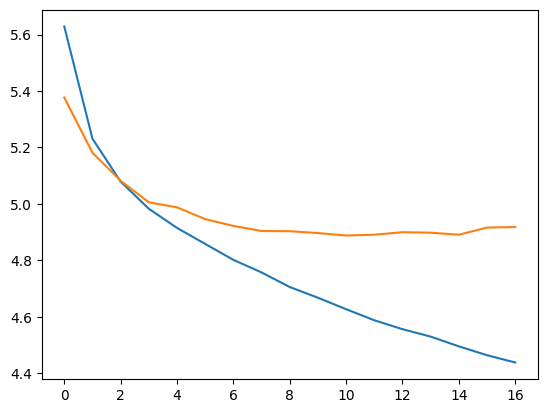

In [5]:
# due to early stopping executed epochs might be different
executed_epochs = len(training_logs.history["loss"])

plt.plot(range(executed_epochs), training_logs.history["loss"])
plt.plot(range(executed_epochs), training_logs.history["val_loss"])

## Evaluation 

In [6]:
reviews_df = pd.read_csv("data/reviews_cleaned_sample.csv", converters={'tokenized': pd.eval})

In [7]:
sample_index = 1

sample_reviews = reviews_df.tokenized.iloc[sample_index:sample_index+2]

In [8]:
data_gen = DataGenerator(sample_reviews, vocabulary=vocabulary)

In [9]:
X_words, y_words = data_gen.create_dataset(config.PREVIOUS_WORDS_CONSIDERED)
embedded_words = data_gen.vectorize(X_words, word2vec, input_size=config.INPUT_SIZE)

In [10]:
y_preds = model.predict(embedded_words)

num_proposed_words = 5
vocabulary_size = len(vocabulary)

5/5 [==============================] - 0s 4ms/step


In [11]:
pwc_and_predicted = []

for index in range(len(X_words)):
    y_pred = y_preds[index]

    predicted_indices = np.argsort(y_pred).reshape(vocabulary_size)[-num_proposed_words:]
    probabilities = np.sort(y_pred).reshape(vocabulary_size)[-num_proposed_words:]

    predicted_probability = {vocabulary[index]: prob for index, prob in zip(predicted_indices, probabilities)}
    
    pwc_and_predicted.append((X_words[index], y_words[index], predicted_probability))

In [12]:
for tokens, _, predicted_words in pwc_and_predicted:
    text = " ".join(tokens)

    print(text + "...")
    print("PREDICTED:")

    for word, probability in predicted_words.items():
        print(f"       {word}: {int(probability*100)}%")

    print()

the favorite film...
PREDICTED:
       and: 80%
       ive: 83%
       ever: 86%
       i: 89%
       of: 93%

favorite film of...
PREDICTED:
       his: 74%
       my: 75%
       a: 91%
       this: 92%
       the: 97%

film of the...
PREDICTED:
       story: 77%
       best: 77%
       plot: 77%
       movie: 78%
       first: 80%

actually more important...
PREDICTED:
       films: 64%
       of: 67%
       movies: 71%
       and: 84%
       than: 95%

more important than...
PREDICTED:
       a: 83%
       that: 85%
       it: 89%
       this: 93%
       the: 94%

and best film...
PREDICTED:
       that: 77%
       and: 81%
       to: 82%
       i: 88%
       of: 91%

best film of...
PREDICTED:
       an: 71%
       his: 72%
       this: 88%
       a: 90%
       the: 96%

for a film...
PREDICTED:
       but: 78%
       i: 79%
       about: 80%
       and: 83%
       that: 94%

a film from...
PREDICTED:
       an: 72%
       it: 77%
       this: 88%
       a: 91%
       the: 96%

fil